In [2]:
import string
import sys
import os
import getopt
import shutil
import subprocess

from matplotlib.pyplot import *
# import pyPLUTO as pypl
# import pyPLUTO.pload as pp
# import pyPLUTO.Image as img
# import pyPLUTO.Tools as tl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline
import pandas as pd

In [3]:
# location of jupyter notebook - everything else is below that 
work_dir = os.getcwd()

In [4]:
# set default values which the user will be allowed to change - see below 

run_name='run002'
grid='low'

t0 = 1.e6
v0 = 300.0
b0 = 18.0 # in nT 
rho0 = 600.0

del_V = 2000.0
del_B = 400.0 # in nT
del_RHO=0.0
dur = 12.0
prof = 0

dict_grid={'low': 500, 'medium': 1000, 'large': 2000}
ngrid=dict_grid[grid]

# The user should provide a run name 
run_name = 'run002'
# The user should select a grid size (low, medium, large)
grid='low'
ngrid = dict_grid[grid]
# Velocity [km/s] should be allowed to be between 0-5000
del_V = 1000
# B [nT ] should be allowed to be between 0 - 1000. (upper limit might be too high)
del_B = 200
# density [cm^-3] pulse - default is zero allowed range 0-500?
del_RHO = 0
# dur [hours] - duration of pulse in hours allowed range 1-24 
dur = 12
# prof [integer 0 or 1] - shape of pulse for magnetic field only can be either sin^2 or sin(dur/2) - so that
# it has an alternating sign
prof = 0

In [5]:
##########################################################################
# Conversion factors from 'normal' units to PLUTO units
#

# To convert from PLUTO time units to hours

time_fac_pluto = 1.49597871e+08/3600

# To convert from PLUTO magnetic field units to nT

b_fac_pluto = 0.0458505

# velocity in PLUTO is already in km/s
# density in PLUTO is already in cm^-3

# convert units for B and time
b0 = b0 / b_fac_pluto
del_B = del_B / b_fac_pluto
dur = dur / time_fac_pluto

In [6]:
# location of template file and the new run specific file we will write
# This file (run_file) will be moved to the run directory - see below

template_file=work_dir+'/cfg/pluto_cfg.ini'
run_file = work_dir+'/cfg/pluto.ini'

In [7]:
##########################################################################
#
# Read template pluto_cfg.ini file and write pluto.ini with user provided
# run parameters
#

# template file is in a 'cfg' sub-directory

template_file=work_dir+'/cfg/pluto_cfg.ini'
run_file = work_dir+'/cfg/pluto.ini'

##########################################################################
#
# Read template pluto_cfg.ini file and write pluto.ini with run parameters
#

dict_replace = {
    'T_0': t0,
    'V0': v0,
    'BP_0': b0,
    'RHO_0': rho0,    
    'RHO_PERT': del_RHO, 
    'X1-grid': ngrid, 
    'V_PERT': del_V,
    'BP_PERT': del_B,
    'CME_DURATION': dur,
    'PROFILE': prof}

out_file = open(run_file, 'w')

# Reading template file line by line and writing out line by line 

with open(template_file, 'r') as fp:

    line = fp.readline()
    while line:
        newline=line
        for sub in dict_replace.keys():
            if (line.find(sub) != -1):
                line2 = line.strip().split(' ')
                last = len(line2)-1
                line2[last] = dict_replace[sub]
                newline=""
                for eachword in line2:
                    newline = newline + ' '+str(eachword)
                newline = newline.lstrip()
                newline = newline+'\n'
                if (sub == 'X1-grid'):
                    newline='X1-grid    1  0.13 '+str(dict_replace[sub])+' u  1.2'+'\n'
        out_file.writelines(newline)
        line = fp.readline()
out_file.close()

In [8]:
wdir = run_name

if not os.path.exists('runs'):
    os.mkdir('runs')
if not os.path.exists('runs/'+wdir):
    os.mkdir('runs/'+wdir)
if not os.path.exists('runs/'+wdir+'/output'):
    os.mkdir('runs/'+wdir+'/output')
        
os.chdir(work_dir)
os.system('chmod -R a+rwx runs')

0

In [9]:
#########################################################################
#
# move pluto.ini and copy definitions.h to current directory
#

os.chdir(work_dir)
src_path = os.getcwd()+'/cfg/'
dst_path = os.getcwd()+'/runs/'+wdir

pluto_ini_org = src_path+'pluto.ini'
pluto_def_org = src_path+'definitions.h'
#pluto_exe_org = os.getcwd()+'/bin/pluto'

pluto_ini_dst = dst_path+'/pluto.ini'
pluto_def_dst = dst_path+'/definitions.h'
#pluto_exe_dst = dst_path+'/pluto'


shutil.move(    pluto_ini_org, pluto_ini_dst)
shutil.copyfile(pluto_def_org, pluto_def_dst)
#shutil.copyfile(pluto_exe_org, pluto_exe_dst)

os.chdir(dst_path)

In [10]:
#########################################################################
#
# Run Pluto - all the output files are in: runs/<run_name>/output
#

with open(dst_path+'/'+'out.txt','w+') as fout:
    with open(dst_path+'err.txt','w+') as ferr:
        out=subprocess.call([work_dir+"/bin/pluto"],stdout=fout,stderr=ferr)

In [11]:
#########################################################################
# 
# Plotting of the results begins here
#

# Convert to nT and Rs

mp=1.6726e-24
b_fac_pluto=0.0458505
r_fac_pluto=2.149e+02
temp_fac_pluto=1
rho_fac_pluto=mp
time_fac_pluto=1.49597871e+08/3600 


b_unit_str    = '(nT)'
r_unit_str    = 'R_${sun}$'
v_unit_str    = '(km/s)'
rho_unit_str  = '(g cm^-^3)'
time_unit_str = '(hours)'

In [12]:
#########################################################################
# 
# read pluto.ini to get cme start time and duration
#
cme_params_dict = {'CME_START_TIME': 0.0, 'CME_DURATION': 0.0}
pluto_ini_file =  dst_path+'/pluto.ini'
with open(pluto_ini_file, 'r') as fp:
    line = fp.readline()
    while line:
        newline = line;
        for sub in cme_params_dict.keys():
            if (line.find(sub) != -1):
                line2 = line.strip().split(' ')
                last = len(line2) - 1
                cme_params_dict[sub] = line2[last]
        line = fp.readline()

cme_start_time = float(cme_params_dict['CME_START_TIME']) * time_fac_pluto
cme_duration   = float(cme_params_dict['CME_DURATION']) * time_fac_pluto
cme_end_time = cme_start_time + cme_duration

In [13]:
#########################################################################
# 
# Read observer file - at inner boundary
#

obs_file = dst_path+'/output/obs_r0.dat'
df = pd.read_table(obs_file,delim_whitespace=True, skiprows=1)
time = df['time'] * time_fac_pluto
bpr0 = df['Bp'] * b_fac_pluto
vrr0 = df['vr']
npr0 = df['rho']
tr0  = df['temp']

In [14]:
#########################################################################
#
# Find the time range we should use for the plot at the inner boundary
#

imax = np.argmax(vrr0)
dt_h = time[imax] - time[(imax-1)] # estimate for the dt in hours

time_max = time[imax]

wwindow = 20.
tmin = round(time_max) - wwindow
tmax = round(time_max) + wwindow

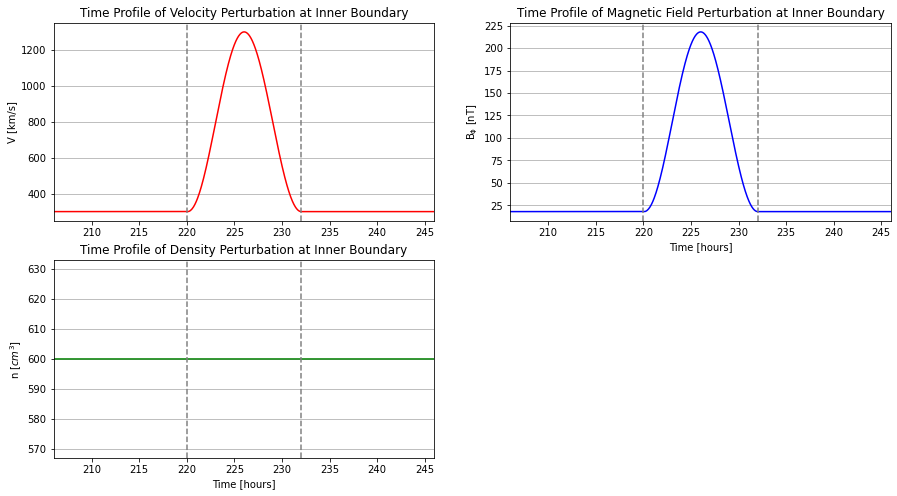

In [15]:
#########################################################################
# 
# Plot the Vr, Bp, and np perturbations at the inner boundary using the observer file
#

f1 = figure(figsize=[15,8], num=1)

ax1 = f1.add_subplot(221)
time = np.array(time)
ydata = np.array(vrr0) 
ax1.plot(time, ydata, color = 'red')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
xlim([tmin,tmax])
#xlabel(r'Time [hours]')
ylabel(r'V [km/s]')
title("Time Profile of Velocity Perturbation at Inner Boundary")
ax1.grid(which='major',axis='y')

ax1 = f1.add_subplot(222)
ydata = np.array(bpr0) 
ax1.plot(time, ydata, color = 'blue')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
xlim([tmin,tmax])
xlabel(r'Time [hours]')
ylabel(r'B$_{\rm \phi}$ [nT]')
title("Time Profile of Magnetic Field Perturbation at Inner Boundary")
ax1.grid(which='major',axis='y')

ax1 = f1.add_subplot(223)
ydata = np.array(npr0) 
ax1.plot(time, ydata, color = 'green')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
xlim([tmin,tmax])
xlabel(r'Time [hours]')
ylabel(r'n [$cm^3$]')
title("Time Profile of Density Perturbation at Inner Boundary")
ax1.grid(which='major',axis='y')

plt.show()

In [16]:
#########################################################################
# 
# Retrieve variables at 1AU from observer file
#
obs_file = dst_path+'/output/obs_1au.dat'

df = pd.read_table(obs_file,delim_whitespace=True, skiprows=1)

time1au = df['time'] * time_fac_pluto
bp1au = df['Bp'] * b_fac_pluto
vr1au = df['vr']
np1au = df['rho']
t1au  = df['temp']


In [17]:
#########################################################################
#
# Find the time range we should use for the plot
#

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

imax = np.argmax(vr1au)

time_max = time1au[imax] # This is the time that Vr has a maximum
# find index of CME start time - start plotting a little before
itmin, time_min = find_nearest(time, cme_start_time)

itmin = itmin - 10

itmax = len(time)-1   
tmin = round(time[itmin])
tmax = round(time[itmax])

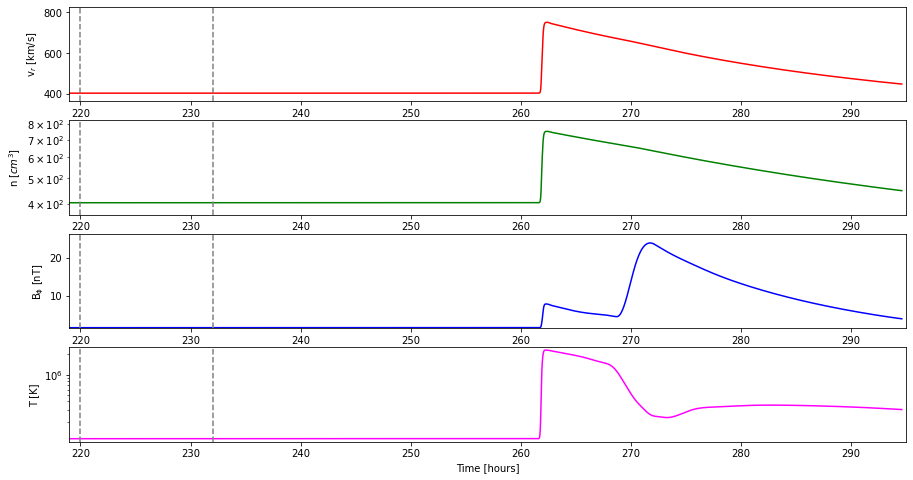

In [18]:
#########################################################################
#
# Plot the variables at 1AU
#


f1 = figure(figsize=[15,8], num=1)

ax1 = f1.add_subplot(411)
time_1au = np.array(time1au)
ydata = np.array(vr1au) 
ax1.plot(time_1au, ydata, color = 'red')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
ymin=min(ydata[itmin:itmax])
ymax=max(ydata[itmin:itmax])     
xlim([tmin,tmax])
ylim([0.9*ymin, 1.1*ymax])
xlabel(r'Time [hours]')
ylabel(r'v$_{r}$ [km/s]')

ax1 = f1.add_subplot(412)
ydata_new = np.array(np1au) 
ax1.plot(time_1au, ydata, color = 'green')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
yscale('log')
ymin=min(ydata[itmin:itmax])
ymax=max(ydata[itmin:itmax])        
xlabel(r'Time [hours]')
ylabel(r'n [$cm^3$]')
xlim([tmin,tmax])
ylim([0.9*ymin, 1.1*ymax])

ax1 = f1.add_subplot(413)
ydata = np.array(bp1au) 
ax1.plot(time_1au, ydata, color = 'blue')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
ymin=min(ydata[itmin:itmax])
ymax=max(ydata[itmin:itmax])         
xlabel(r'Time [hours]')
ylabel(r'B$_{\rm \phi}$ [nT]')
xlim([tmin,tmax])
ylim([0.9*ymin, 1.1*ymax])

ax1 = f1.add_subplot(414)
ydata = np.array(t1au) 
ax1.plot(time_1au, ydata, color = 'magenta')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
yscale('log')
ymin=min(ydata[itmin:itmax])
ymax=max(ydata[itmin:itmax])     
xlabel(r'Time [hours]')
ylabel(r'T [K]')
xlim([tmin,tmax])
ylim([0.9*ymin, 1.1*ymax])


plt.show()

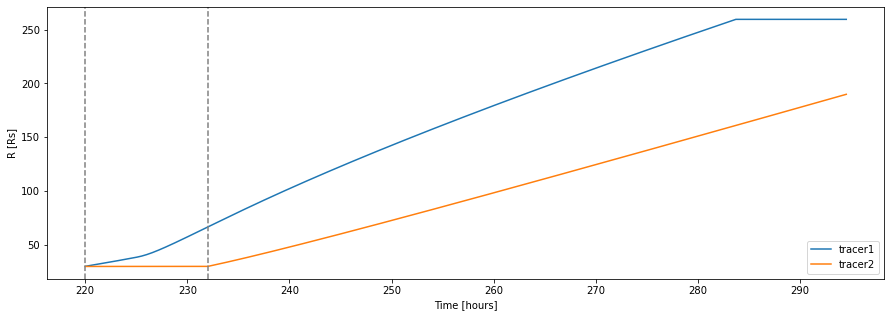

In [19]:
#########################################################################
#
# Plot Tracers
#

trc_file = dst_path+'/output/tracers.dat'
df = pd.read_table(trc_file,delim_whitespace=True, skiprows=0)
time = df['time'] * time_fac_pluto
tracer1 = df['tracer1'] * r_fac_pluto
tracer2 = df['tracer2'] * r_fac_pluto

f1 = figure(figsize=[15,5], num=1)
ax1 = f1.add_subplot(111)
ax1.plot(time, tracer1, label = 'tracer1')
ax1.plot(time, tracer2, label = 'tracer2')
ax1.axvline(x = cme_start_time, color = 'grey', linestyle = '--')
ax1.axvline(x = cme_end_time, color = 'grey', linestyle = '--')
xlabel(r'Time [hours]')
ylabel(r'R [Rs]')
legend()
plt.show()

In [20]:
#########################################################################
#
# Read the 2D time/R data
#

pluto_dir = dst_path+'/output/'
nlinf = pypl.nlast_info(w_dir=pluto_dir)
D=pp.pload(nlinf['nlast'],w_dir=pluto_dir,datatype='dbl')

time2d = pypl.read_time(w_dir=pluto_dir,datatype='dbl')

time2d = np.array(time2d, dtype=np.float32) 

r=D.x1 * r_fac_pluto
time2d = time2d * time_fac_pluto
nr=D.n1
nt = nlinf['nlast']
nt1=nt+1
vr2d = np.zeros((nr,nt1))
np2d = np.zeros((nr,nt1))
bp2d = np.zeros((nr,nt1))
t2d = np.zeros((nr,nt1))

for nframe in range(0, nt1):
    D=pp.pload(nframe,w_dir=pluto_dir,datatype='dbl')
    vr2d[:,nframe] = D.vx1
    np2d[:,nframe] = D.rho
    bp2d[:,nframe] = D.Bx3
    t2d[:, nframe] = D.T

NameError: name 'pypl' is not defined

In [21]:
#########################################################################
# Make 2D plots (time,R) for the calculations 
# For density and temperature use a log -scale
#

shrink=0.8

#tmin=120
#tmax=200

tmin2d = 130 # We can hard code this because we know when the perturbation is introduced
tmax2d = tmax # This can be set to the same value as in the 1D plots

I=img.Image()
mfig = figure(8,figsize=[15,15])
Nrows,Ncols=2,2

# Vr
icount = 1
data = vr2d
mfig.add_subplot(Nrows,Ncols,icount)
plt.pcolormesh(time2d, r, data,vmin=None,vmax=None,shading='auto',cmap='rainbow')
plt.ylabel('R [R$_s$]')
plt.axis([tmin2d,tmax2d,r.min(),r.max()])
colorbar(orientation='vertical',shrink=shrink)
mytitle = 'Vr [km/s] '
title(mytitle)
plt.axhline(y = r_fac_pluto, color = 'black', linestyle = '--')
plt.axvline(x = cme_start_time, color = 'black', linestyle = '--')
plt.axvline(x = cme_end_time, color = 'black', linestyle = '--')

# Np
icount = icount + 1
data = np2d
mfig.add_subplot(Nrows,Ncols,icount)
plt.pcolormesh(time2d, r, data,norm=LogNorm(vmin=data.min(), vmax=data.max()), shading='auto')
plt.ylabel('R [R$_s$]')
plt.axis([tmin2d,tmax2d,r.min(),r.max()])
colorbar(orientation='vertical',shrink=shrink)
mytitle = 'n [$cm^3$]'
title(mytitle)
plt.axhline(y = r_fac_pluto, color = 'black', linestyle = '--')
plt.axvline(x = cme_start_time, color = 'black', linestyle = '--')
plt.axvline(x = cme_end_time, color = 'black', linestyle = '--')

# Bp
icount = icount + 1
data = bp2d
mfig.add_subplot(Nrows,Ncols,icount)
plt.pcolormesh(time2d, r, data* b_fac_pluto, vmin = -50, vmax = 50, shading='auto',cmap='RdBu_r')
plt.ylabel('R [R$_s$]')
plt.xlabel('$Time [hours]$')
plt.axis([tmin2d,tmax2d,r.min(),r.max()])
colorbar(orientation='vertical',shrink=shrink)
mytitle = 'B$\\phi$'
title(mytitle)
plt.axhline(y = r_fac_pluto, color = 'black', linestyle = '--')
plt.axvline(x = cme_start_time, color = 'black', linestyle = '--')
plt.axvline(x = cme_end_time, color = 'black', linestyle = '--')

# Temperature
icount = icount + 1
data = t2d
mfig.add_subplot(Nrows,Ncols,icount)
plt.pcolormesh(time2d, r, data, norm=LogNorm(vmin=data.min(), vmax=data.max()), shading='auto',cmap='rainbow')
plt.ylabel('R [R$_s$]')
plt.xlabel('$Time [hours]$')
plt.axis([tmin2d,tmax2d,r.min(),r.max()])
colorbar(orientation='vertical',shrink=shrink)
mytitle = 'T [K]'
title(mytitle)
plt.axhline(y = r_fac_pluto, color = 'black', linestyle = '--')
plt.axvline(x = cme_start_time, color = 'black', linestyle = '--')
plt.axvline(x = cme_end_time, color = 'black', linestyle = '--')
plt.show()


NameError: name 'img' is not defined

In [22]:
#########################################################################
#
# Based on the above plots we can try to look at snapshots at 
# a few time points 
#

ntps = 8
dt = round((tmax-tmin)/ntps)
tps = np.arange(round(tmin), round(tmax), dt)
    
vr_list, bp_list, rho_list, temp_list = [], [], [], []

for nframe in tps: 
    idx = np.searchsorted(time2d, nframe, side="left")
    print(idx)
    D=pp.pload(idx,w_dir=pluto_dir,datatype='dbl')
    vr   = D.vx1
    bp   = D.Bx3 * b_fac_pluto
    rho  = D.rho
    temp = D.T
    
    vr_list.append(vr.tolist())
    bp_list.append(bp.tolist())
    rho_list.append(rho.tolist())
    temp_list.append(temp.tolist())
    r = np.array(D.x1, dtype=np.float32) * r_fac_pluto
        

NameError: name 'time2d' is not defined

In [23]:
colors = cm.rainbow(np.linspace(0, 1, len(vr_list)))
    
I=img.Image()    
mfig = figure(4,figsize=[25,15])
Nrows,Ncols=2,2
icount = 0
    
jcount = 0
icount = icount + 1    
mfig.add_subplot(Nrows,Ncols,icount)    
for ydata, clr in zip(vr_list, colors):
    ydata_new = np.array(ydata) 
    label = str(tps[jcount])+ ' Hours'
    jcount = jcount + 1
    plt.plot(r, ydata_new, color = clr, label = label)
plt.legend(loc='upper left', frameon = False)
plt.axvline(x=r_fac_pluto, c='grey', ls='--')
ylabel (r'V$_{\rm r}$')
xlabel (r'R$_{\rms}$')

jcount = 0
icount = icount + 1
mfig.add_subplot(Nrows,Ncols,icount)
for ydata, clr in zip(rho_list, colors):
    ydata_new = np.array(ydata) 
    label = str(tps[jcount])+ ' Hours'
    jcount = jcount + 1
    plt.plot(r, ydata_new, color = clr, label = label)

plt.legend(loc='upper right', frameon = False)
plt.axvline(x=r_fac_pluto, c='grey', ls='--')
ylabel (r'n [$cm^3$]')
xlabel (r'R$_{\rms}$')
yscale('log')

jcount = 0
icount = icount + 1
mfig.add_subplot(Nrows,Ncols,icount)
for ydata, clr in zip(bp_list, colors):
    ydata_new = np.array(ydata) 
    label = str(tps[jcount])+ ' Hours'
    jcount = jcount + 1
    plt.plot(r, ydata_new, color = clr, label = label)

plt.legend(loc='upper right', frameon = False)
plt.axvline(x=r_fac_pluto, c='grey', ls='--')
ylabel(r'B$_{\rm \phi}$ [nT]')
xlabel (r'R$_{\rms}$')

jcount = 0
icount = icount + 1
mfig.add_subplot(Nrows,Ncols,icount)
for ydata, clr in zip(temp_list, colors):
    ydata_new = np.array(ydata) 
    label = str(tps[jcount])+ ' Hours'
    jcount = jcount + 1
    plt.plot(r, ydata_new, color = clr, label = label)

plt.legend(loc='upper right', frameon = False)
plt.axvline(x=r_fac_pluto, c='grey', ls='--')
ylabel(r'T [K]')
xlabel (r'R$_{\rms}$')

plt.show()

NameError: name 'img' is not defined